In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from os import system

## Widgets
from ipywidgets import interact_manual, interactive_output
import ipywidgets as wd

## Visualization
from IPython.display import display, clear_output, Pretty

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.attachmentRateCFT as arCFT

# Breakthrough curve of a column experiment

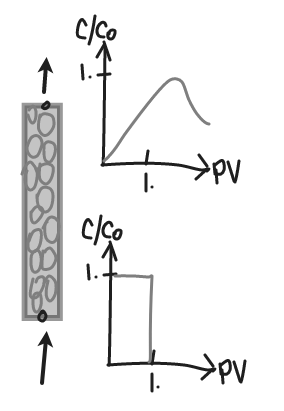

### Initial configuration
**Define the paths to input files and PFLOTRAN**

In [2]:
templateFiles = ["../TEMPLATES/columns_1D/tpl_Richards_models_TJ.in",\
                 "../TEMPLATES/columns_1D/tpl_Richards_models.in"]

## PFLOTRAN
#Pretty(templateFiles[0])

In [3]:
ColumnModel = mo.Model(templateFile=templateFiles[0],
                       execPath="$PFLOTRAN_DIR/toCommit/pflotran/build/pflotran")

Notice that the input file is by default a file named `pflotran.in` and not the template.

In [4]:
print(ColumnModel)

$PFLOTRAN_DIR/toCommit/pflotran/build/pflotran -pflotranin ./pflotran.in


## Case parameters

### Inflow concentration and pulse duration

In [5]:
Temperature = pm.Real("<referenceTemperature>", value=10.0 , units="C")
ConcentrationAtInlet = pm.Real("<initialConcentration>", value=1.00E-10, units="mol/L")
InjectTimeInPoreVol = 1.0

### Grid

In [6]:
nX = pm.Integer("<nX>",value=1)
nY = pm.Integer("<nY>",value=1)
nZ = pm.Integer("<nZ>",value=51)

## Time stepping 
These parameters have a fixed value but are calculated from other parameters

In [7]:
ElutionTime  = pm.Real(tag="<elutionTime>",units="s")
EndTime      = pm.Real(tag="<endTime>", units="d")
TimeStep     = pm.Real(tag="<timeStep>",units="h")
OutTimeStep  = pm.Real(tag="<writeTime>",units="h")

## User-modifiable parameters
Parameters whose values are set by a widget, notice they don't have an assigned value yet

In [8]:
## General
FlowVelocity   = pm.WithSlider(tag="<darcyVel>",units="m/s",mathRep="$$\\vec{q}$$")
ColumnLenght   = pm.WithSlider(tag="<colLenght>",value=0.50,units="m",mathRep="$$L$$")
LongDisp       = pm.WithSlider(tag="<longDisp>",units="m",mathRep="$$\\alpha_L$$")
Porosity       = pm.WithSlider(tag="<porosity>", value=0.37,units="adim",mathRep="$$\\theta$$")
RateDetachment = pm.WithSlider(tag="<kdet>",units="1/h",mathRep="$$k_{det}$$")
                               
## Attachment Rate (CFT)
AlphaEffic     = pm.WithSlider(tag="<alphaEfficiency>",units="-",mathRep="$$\\alpha$$")
GrainSize      = pm.WithSlider(tag="<diamCollector>",units="m",mathRep="$$d_c$$")
ParticleDiam   = pm.WithSlider(tag="<diamParticle>",units="m",mathRep="$$d_p$$")
HamakerConst   = pm.WithSlider(tag="<hamakerConstant>",units="J/m",mathRep="$$A$$")
ParticleDens   = pm.WithSlider(tag="<rhoParticle>",units="J/m",mathRep="$$\\rho_p$$")

**Check created parameters**
The value of a parameter can be printed with their corresponding tag:

In [9]:
print(Porosity)

$$\theta$$ = 1.000E+00


In [10]:
print(RateDetachment)

$$k_{det}$$ = 1.000E+00


In [11]:
print(RateDetachment.slider)

FloatLogSlider(value=1.0)


### List of all parameters

A list of all the parameters we have created so far is automatically updated each time a `pm.Parameter` object is instantiated.

In [12]:
listOfParameters = pm.Parameter.list_of_vars()

for i in listOfParameters:
    print(i)

<referenceTemperature> = 1.000E+01
<initialConcentration> = 1.000E-10
<nX> = 1
<nY> = 1
<nZ> = 51
<elutionTime> = <None>
<endTime> = <None>
<timeStep> = <None>
<writeTime> = <None>
$$\vec{q}$$ = 1.000E+00
$$L$$ = 1.000E+00
$$\alpha_L$$ = 1.000E+00
$$\theta$$ = 1.000E+00
$$k_{det}$$ = 1.000E+00
$$\alpha$$ = 1.000E+00
$$d_c$$ = 1.000E+00
$$d_p$$ = 1.000E+00
$$A$$ = 1.000E+00
$$\rho_p$$ = 1.000E+00


## Plotting results
Plotting functions are stored in `plotBTC.py`

In [13]:
import jupypft.plotBTC as plotBTC

## Personalize sliders for user interaction

This cell below assigns `FloatLog` and `Float`sliders to the parameters we want to modify within the notebook

In [14]:
## General
Porosity.slider = wd.FloatSlider(value=0.35, min=0.05, max=0.95, step=0.05)
FlowVelocity.slider = wd.FloatLogSlider(value=2.78E-6,base=10, min=-10, max=-3, step=0.1)
ColumnLenght.slider = wd.FloatSlider(value=0.50, min=0.10, max=2.0, step=0.1)
LongDisp.slider     = wd.FloatLogSlider(value=1E-12,base=10, min=-12, max=0, step=0.1)
RateDetachment.slider = wd.FloatLogSlider(value=0.0026,base=10, min=-30, max=1, step=0.1)

## Attachment rates
GrainSize.slider    = wd.FloatLogSlider(value=2.0E-3,base=10, min=-4, max=-1, step=0.1)
ParticleDiam.slider = wd.FloatLogSlider(value=1.0E-7,base=10, min=-9, max=-4, step=0.1)
HamakerConst.slider = wd.FloatLogSlider(value=5.0E-21,base=10, min=-22, max=-18, step=0.1)
ParticleDens.slider = wd.FloatSlider(value=1050.0,min=0.0, max=4000, step=100)
AlphaEffic.slider   = wd.FloatLogSlider(value=1E-5,base=10, min=-5, max=0, step=0.1)

### Run the PFLOTRAN case
Here we declare a dummy function that is activated when the widget Interact button is pressed. It reads the values on the sliders for each parameter and assing them to the corresponding `pm.Parameter` object.

In [15]:
timePoreVolume = 0.0

def AssignValues():    
    global timePoreVolume
    timePoreVolume = ColumnLenght.value * Porosity.value / FlowVelocity.value #s
    
    CFL =  1.0
    deltaX = ColumnLenght.value/nZ.value

    #Calculate linked parameters
    ElutionTime.value = InjectTimeInPoreVol * timePoreVolume #s
    EndTime.value     = 5.0 * InjectTimeInPoreVol * timePoreVolume / 3600 #h
    TimeStep.value    = CFL*deltaX*Porosity.value/FlowVelocity.value
    OutTimeStep.value = EndTime.value/100.
    
    print("PV -> t = {:.2E} [h]".format(timePoreVolume/3600))

In [16]:
def RunAll():
    AssignValues()
    #Copy the template as a runFile
    ColumnModel.cloneTemplate()
    
    #Replace the tags in the runFile with values
    for parameter in listOfParameters:
        ColumnModel.replaceTagInFile(parameter)
    
    #Run PFLOTRAN
    ColumnModel.runModel()
    
    #Reformat the results file to a CSV
    ColumnModel.fixedToCSV(outputFile="pflotran-obs-0.pft")
    
    #Make plots
    clear_output()
    plotBTC.xyPlotLine(
        normalizeXWith = timePoreVolume/3600.,
        normalizeYWith = ConcentrationAtInlet.value,
        legend = "BTC")
    
def printkAtt():
    #Calculate the attachment rate using python
    _,kAtt = arCFT.attachmentRate(
        dp = ParticleDiam.value,
        dc = GrainSize.value,
        q  = FlowVelocity.value,
        theta = Porosity.value,
        visco = 0.0008891,
        rho_f = 999.79,
        rho_p = ParticleDens.value,
        A = HamakerConst.value,
        T = Temperature.value + 273.15,
        alpha=AlphaEffic.value,
        debug=False)
    return kAtt

With `interactive_output`, the user-interactive sliders are shown: 

In [17]:
##First slot accordion - General parameters
ui1_1 = wd.VBox([ColumnLenght.ui,\
                 LongDisp.ui,\
                 FlowVelocity.ui,\
                 Porosity.ui,\
                 RateDetachment.ui])

##Second tab - Attachment rate & CFT
ui1_2 = wd.VBox([GrainSize.ui,\
               ParticleDiam.ui,\
               HamakerConst.ui,\
               ParticleDens.ui,\
               AlphaEffic.ui,\
                  ])

##3rd tab - Run model
ui1_3 = wd.Button(
    description='Run PFLOTRAN',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run PFLOTRAN',
    icon='check'
)

ui1 = wd.Accordion(children=[ui1_1,ui1_2,ui1_3])
ui1.set_title(0,"General")
ui1.set_title(1,"Attachment rate (CFT)")
ui1.set_title(2,"Run Model")

In [18]:
ui2_1 = wd.Output()
ui2_2 = wd.HTML()

def on_button_clicked(_):
    with ui2_1: RunAll()
    ui2_2.value = printkAtt()

ui1_3.on_click(on_button_clicked)

ui2 = wd.Tab(children=[ui2_1,ui2_2])
ui2.set_title(0,"Breakthrough curve")
ui2.set_title(1,"CFT Calc")

In [19]:
ui = wd.TwoByTwoLayout(top_left=ui1,
                  top_right=ui2)
display(ui)

TwoByTwoLayout(children=(Accordion(children=(VBox(children=(HBox(children=(HTMLMath(value='$$L$$'), FloatSlide…

In [20]:
Pretty("./pflotran.in")

./pflotran.in